In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
stopword_list = get_stopwords("../marathi-stopwords.txt")

In [5]:
x_train = training_data.text.apply(lambda x: preprocess_data(stopword_list, x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: preprocess_data(stopword_list, x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [11]:
dump(tokenizer, "../tokenizers/DL-tokenizer-100.pk1")

['../tokenizers/DL-tokenizer-100.pk1']

In [12]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [13]:
vocab = tokenizer.word_index

In [15]:
start = process_time()
embedding_path = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.cleaned.ft.skipgram.d300.vec"
embedding_matrix = get_embedding_matrix(embedding_path, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix.shape

51795
Total time taken:  4.282939727999999


(51802, 300)

In [16]:
input_dim = embedding_matrix.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  51802
Embedding dimensions:  300
Input sentence dimensions:  100


In [17]:
myCB = myCallbacks(metrics='acc', threshold=0.95)

# Feed-Forward Neural Network Model

In [18]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.015))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15540600  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 15,562,076
Trainable params: 21,476
Non-trainable params: 15,540,600
_________________________________________________________________


In [19]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 5s 4ms/step - loss: 1.1788 - acc: 0.6950 - val_loss: 0.8913 - val_acc: 0.7524
Epoch 2/8
1313/1313 [==============================] - 5s 4ms/step - loss: 0.8474 - acc: 0.7558 - val_loss: 0.8376 - val_acc: 0.7579
Epoch 3/8
1313/1313 [==============================] - 5s 4ms/step - loss: 0.8051 - acc: 0.7600 - val_loss: 0.8487 - val_acc: 0.7439
Epoch 4/8
1313/1313 [==============================] - 5s 4ms/step - loss: 0.7841 - acc: 0.7605 - val_loss: 0.7890 - val_acc: 0.7603
Epoch 5/8
1313/1313 [==============================] - 5s 4ms/step - loss: 0.7668 - acc: 0.7627 - val_loss: 0.7807 - val_acc: 0.7579
Epoch 6/8
1313/1313 [==============================] - 5s 4ms/step - loss: 0.7526 - acc: 0.7655 - val_loss: 0.7908 - val_acc: 0.7442
Epoch 7/8
1313/1313 [==============================] - 5s 3ms/step - loss: 0.7373 - acc: 0.7677 - val_loss: 0.7509 - val_acc: 0.7667
Epoch 8/8
1313/1313 [==============================] - 5s 4ms/step - 

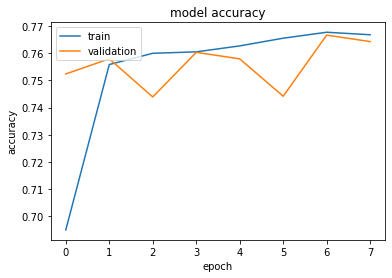

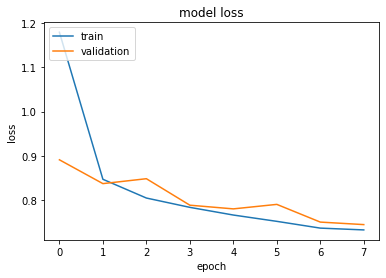

In [20]:
plot_curves(history1)

In [ ]:
name = "FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585.h5")

In [21]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [22]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.7642857142857142

Precision:  [0.69761905 0.74439462 0.82306684 0.78720787]
Average Precision:  0.7630720949868286

Recall:  [0.69761905 0.88239203 0.70960452 0.65979381]
Average nRecall:  0.7373523521010305

F1-Score:  [0.69761905 0.80754029 0.76213592 0.71789119]
Average F1-Score:  0.746296612591529


# CNN Model

In [23]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.02))
myCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15540600  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 15,636,924
Trainable params: 96,324
Non-trainable params: 15,540,600
_________________________________________________________________


In [24]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 26s 20ms/step - loss: 0.9397 - acc: 0.7998 - val_loss: 0.7528 - val_acc: 0.8392
Epoch 2/8
1313/1313 [==============================] - 36s 27ms/step - loss: 0.7783 - acc: 0.8202 - val_loss: 0.8029 - val_acc: 0.8032
Epoch 3/8
1313/1313 [==============================] - 27s 21ms/step - loss: 0.7815 - acc: 0.8237 - val_loss: 0.7710 - val_acc: 0.8307
Epoch 4/8
1313/1313 [==============================] - 25s 19ms/step - loss: 0.7819 - acc: 0.8251 - val_loss: 0.7493 - val_acc: 0.8344
Epoch 5/8
1313/1313 [==============================] - 25s 19ms/step - loss: 0.7831 - acc: 0.8234 - val_loss: 0.8119 - val_acc: 0.8087
Epoch 6/8
1313/1313 [==============================] - 25s 19ms/step - loss: 0.7806 - acc: 0.8251 - val_loss: 0.7571 - val_acc: 0.8365
Epoch 7/8
1313/1313 [==============================] - 26s 20ms/step - loss: 0.7840 - acc: 0.8245 - val_loss: 0.7348 - val_acc: 0.8447
Epoch 8/8
1313/1313 [==============================] - 

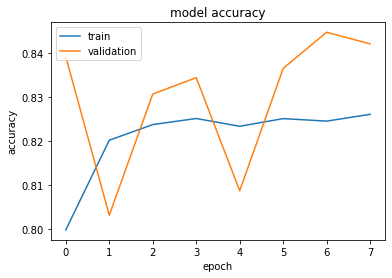

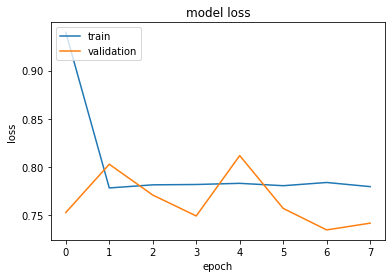

In [25]:
plot_curves(history2)

In [ ]:
name ="CNN/CNN-n1.64n2.64-kr0015-vacc8632"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myCNN = model_load("../models/CNN/CNN-n1.64n2.64-kr0015-vacc8632.h5")

In [26]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [27]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8420634920634921

Precision:  [0.84679666 0.79507728 0.90073529 0.87995338]
Average Precision:  0.8556406516954446

Recall:  [0.72380952 0.92292359 0.83050847 0.77835052]
Average nRecall:  0.8138980254723949

F1-Score:  [0.7804878  0.85424354 0.86419753 0.82603939]
Average F1-Score:  0.8312420663715511


# Bi-LSTM Model

In [28]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix, 
                           input_len, 
                           trainable=False, 
                           n1=32, n2=32, 
                           d=0.25)
myLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          15540600  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           85248     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 15,628,060
Trainable params: 87,460
Non-trainable params: 15,540,600
_________________________________________________________________


In [29]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 170s 130ms/step - loss: 0.4814 - acc: 0.8209 - val_loss: 0.3888 - val_acc: 0.8566
Epoch 2/8
1313/1313 [==============================] - 181s 138ms/step - loss: 0.3771 - acc: 0.8597 - val_loss: 0.3579 - val_acc: 0.8685
Epoch 3/8
1313/1313 [==============================] - 197s 150ms/step - loss: 0.3470 - acc: 0.8723 - val_loss: 0.3574 - val_acc: 0.8638
Epoch 4/8
1313/1313 [==============================] - 198s 150ms/step - loss: 0.3222 - acc: 0.8801 - val_loss: 0.3489 - val_acc: 0.8717
Epoch 5/8
1313/1313 [==============================] - 206s 157ms/step - loss: 0.3004 - acc: 0.8888 - val_loss: 0.3403 - val_acc: 0.8735
Epoch 6/8
1313/1313 [==============================] - 210s 160ms/step - loss: 0.2838 - acc: 0.8931 - val_loss: 0.3390 - val_acc: 0.8735
Epoch 7/8
1313/1313 [==============================] - 244s 186ms/step - loss: 0.2686 - acc: 0.9007 - val_loss: 0.3452 - val_acc: 0.8704
Epoch 8/8
1313/1313 [====================

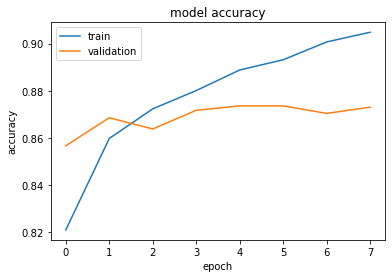

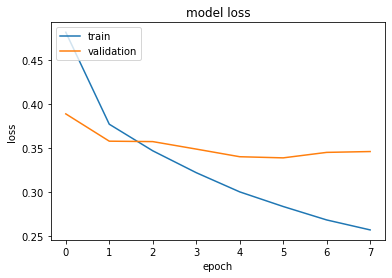

In [30]:
plot_curves(history3)

In [ ]:
name= "LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myLSTM = model_load("../models/LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868.h5")

In [31]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [32]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.873015873015873

Precision:  [0.88857939 0.85003036 0.91263282 0.87162891]
Average Precision:  0.8807178694003255

Recall:  [0.75952381 0.93023256 0.87344633 0.83298969]
Average nRecall:  0.8490480965171524

F1-Score:  [0.81899872 0.88832487 0.8926097  0.85187138]
Average F1-Score:  0.862951166256267
